In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

In [3]:
# Load dataset
df = pd.read_csv("train.csv", encoding='ISO-8859-1')


In [4]:
# Preprocess and clean
df_small = df[['text', 'sentiment']].dropna()
df_small['text'] = df_small['text'].str.lower().str.replace('[^a-z\\s]', '', regex=True)

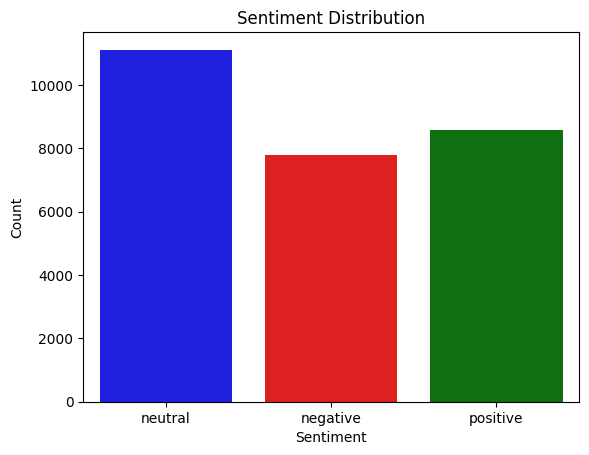

In [5]:
# Visualize sentiment distribution
sns.countplot(
    x='sentiment',
    data=df,
    hue='sentiment',
    palette={'positive': 'green', 'neutral': 'blue', 'negative': 'red'},
    legend=False
)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.savefig("Sentiment Distribution.png", dpi=300)
plt.show()

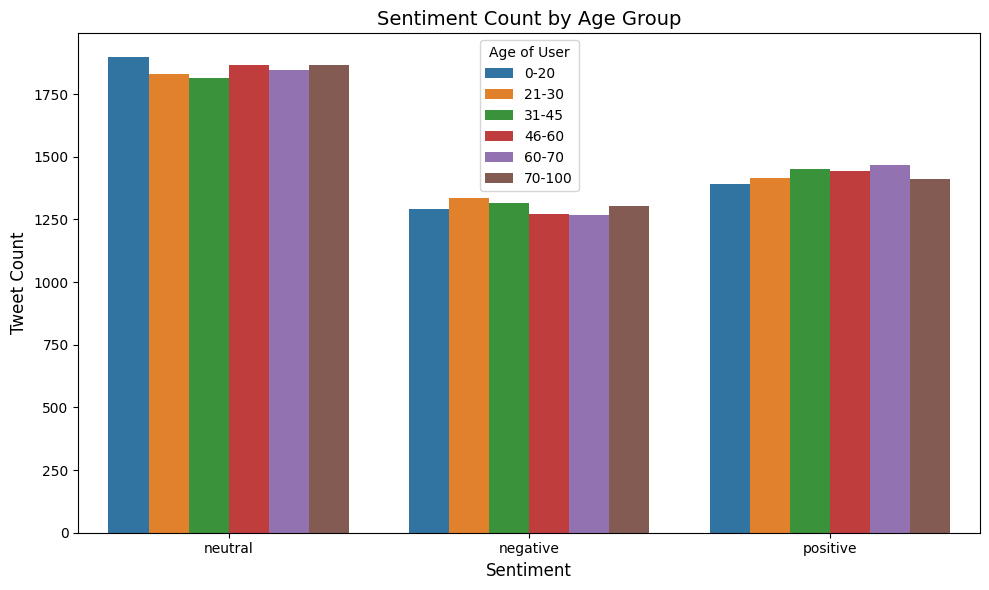

In [7]:
# Clean 'Age of User' column
df['Age of User'] = df['Age of User'].astype(str).str.strip()
df = df[df['Age of User'].notna() & (df['Age of User'] != '')]

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df,x="sentiment",hue="Age of User")
plt.title("Sentiment Count by Age Group", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Tweet Count", fontsize=12)
plt.legend(title="Age of User")
plt.tight_layout()
plt.savefig("Sentiment Count by Age Group.png", dpi=300)
plt.show()


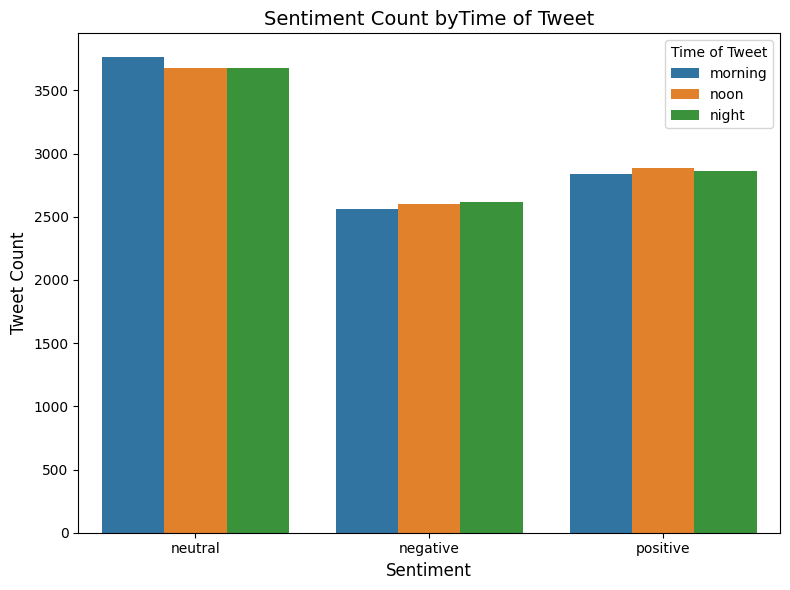

In [8]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="sentiment", hue="Time of Tweet")
plt.title("Sentiment Count byTime of Tweet", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Tweet Count", fontsize=12)
plt.tight_layout()
plt.savefig("Sentiment Count byTime of Tweet.png", dpi=300)
plt.show()


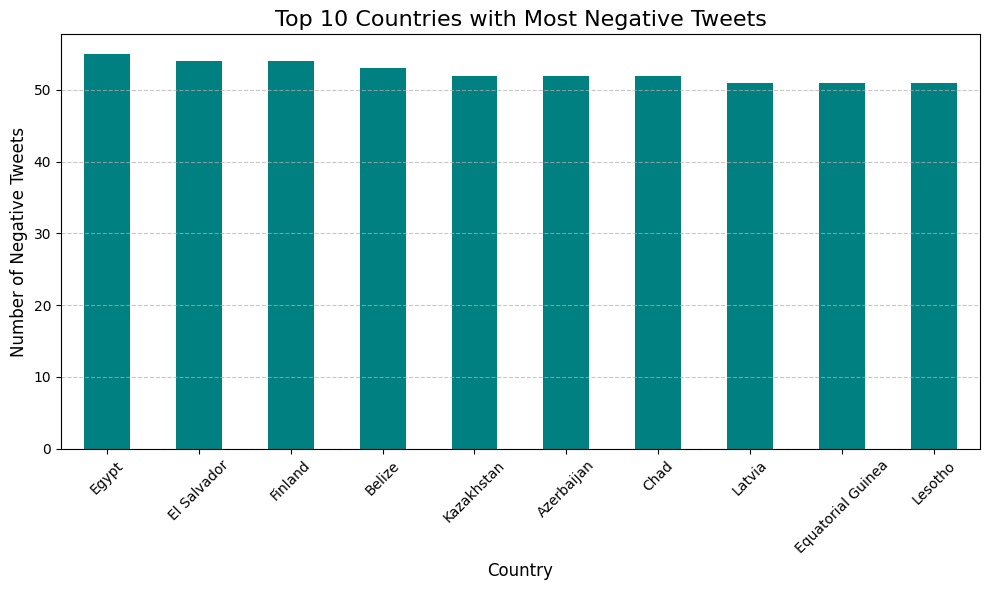

In [9]:
# Filter and plot
plt.figure(figsize=(10, 6))
df[df['sentiment'] == 'negative']['Country'].value_counts().head(10).plot(
    kind='bar',
    color='teal'
)

# Customization
plt.title('Top 10 Countries with Most Negative Tweets', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Negative Tweets', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("Most Negative Tweets.png", dpi=300)
plt.show()

In [10]:
# Prepare data for model
X = df_small['text']
y = df_small['sentiment']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [11]:
# Tokenization
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train.astype(str))
X_test_seq = tokenizer.texts_to_sequences(X_test.astype(str))

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [12]:
# Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


C:\Users\rk871\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
# Training
history = model.fit(X_train_pad, y_train, epochs=5, validation_split=0.1, batch_size=32)


Epoch 1/5
619/619 ━━━━━━━━━━━━━━━━━━━━ 58s 77ms/step - accuracy: 0.5260 - loss: 0.9349 - val_accuracy: 0.7108 - val_loss: 0.6940
Epoch 2/5
619/619 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.7643 - loss: 0.5843 - val_accuracy: 0.7208 - val_loss: 0.6740
Epoch 3/5
619/619 ━━━━━━━━━━━━━━━━━━━━ 82s 76ms/step - accuracy: 0.8330 - loss: 0.4417 - val_accuracy: 0.7126 - val_loss: 0.7275
Epoch 4/5
619/619 ━━━━━━━━━━━━━━━━━━━━ 83s 78ms/step - accuracy: 0.8789 - loss: 0.3409 - val_accuracy: 0.6967 - val_loss: 0.8291
Epoch 5/5
619/619 ━━━━━━━━━━━━━━━━━━━━ 83s 79ms/step - accuracy: 0.9105 - loss: 0.2635 - val_accuracy: 0.7003 - val_loss: 0.9298


In [15]:
# Save tokenizer and label encoder
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [26]:
# Save model
model.save('sentiment_model.h5')

In [17]:
# Predict function
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text.lower()])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    probs = model.predict(pad)[0]
    label_index = np.argmax(probs)
    label = label_encoder.inverse_transform([label_index])[0]
    confidence = float(probs[label_index])
    return label, confidence

In [18]:
x=predict_sentiment("product is good")
x

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


('positive', 0.9925372004508972)